# Лабораторная работа
Евтеев Илья 18БИ-1

Будем работать с данными [kaggle-соревнования](https://www.kaggle.com/c/prudential-life-insurance-assessment), завершившегося зимой 2016 года. 

__Задача соревнования:__ по характеристикам человека и его заявки на медицинскую страховку предсказать степень риска, характерную для данной страховки.

Целевой признак (степень риска) в задаче номинальный: целые числа от 1 до 8. 

Мы будем визуализировать только обучающую выборку. Часто при решении конкурсов полезно визуализировать также тестовую выборку (на которой нужно сделать предсказание), чтобы убедиться, что данные идентичны.

Часть кода, необходимого для построения графиков, уже написана; для другой части даны инструкции, по которым вам нужно написать скрипт; такие ячейки помечены # Код X, X - число. Кроме того, вам необходимо проанализировать графики, ответив на вопросы.

In [4]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

In [40]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

Считываем данные:

In [42]:
data = pandas.read_csv("train.csv", na_values="NaN")

In [43]:
data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


Часто в соревнованиях смысл признаков не известен, в нашем соревновании это не совсем так. Вы можете посмотреть описание признаков на [странице с данными](https://www.kaggle.com/c/prudential-life-insurance-assessment/data). 

Резюме: значение известно только для нескольких признаков, для остальных известна только группа, к которой этот признак принадлежит (например, медицинские данные) и тип признака: вещественный, целочисленный или категориальный. При этом неясно, можно ли считать категориальные признаки упорядоченными.

Создадим три списка признаков, соответствующие их группам: вещественные, целочисленные и категориальные (эти списки даны на странице соревнования). Уберем признак Id, так как он не несет смысловой нагрузки. 

Если бы типы признаков были не даны, нам бы пришлось вручную просматривать все 128 признаков, чтобы понять, какие значения они принимают. 

In [44]:
real_features = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI", "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                 "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
discrete_features = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
cat_features = data.columns.drop(real_features).drop(discrete_features).drop(["Id", "Response"]).tolist()

### Первичный анализ

Есть набор стандартных приемов визуализации, которые нужно попробовать, когда вы начинаете работу с набором данных; к ним относятся построение гистограмм признаков (histogram, density estimation), статистик, оценка зависимости целевого признака от остальных (boxplot, scatterplot, violinplot), визуализация пар признаков (как правило, scatterplot). Конкретный вид графика, который вам подходит, зависит от типа признаков, хороший обзор приведен в разделе Plotting functions [туториала seaborn](https://stanford.edu/~mwaskom/software/seaborn/tutorial.html).

Сначала рассмотрим числовые признаки, затем - категориальные.

##### Выведем статистики вещественных и целочисленных признаков:

In [45]:
data[real_features].describe()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59362.000000,52602.000000,48527.000000,33985.000000,30725.000000,25140.000000,40197.000000,17570.000000
mean,0.328952,0.405567,0.707283,0.292587,0.469462,0.077582,0.006283,0.361469,0.001733,0.474550,0.497737,0.444890,0.484635
std,0.282562,0.197190,0.074239,0.089037,0.122213,0.082347,0.032816,0.349551,0.007338,0.154959,0.140187,0.163012,0.129200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,0.238806,0.654545,0.225941,0.385517,0.035000,0.000000,0.060000,0.000400,0.362319,0.401961,0.323944,0.401786
50%,0.230769,0.402985,0.709091,0.288703,0.451349,0.060000,0.000000,0.250000,0.000973,0.463768,0.519608,0.422535,0.508929
75%,0.487179,0.567164,0.763636,0.345188,0.532858,0.100000,0.000000,0.550000,0.002000,0.579710,0.598039,0.563380,0.580357
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943662,1.000000


In [46]:
data[discrete_features].describe()

,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32
count,50492.000000,557.000000,14785.000000,3801.000000,1107.000000
mean,7.962172,141.118492,123.760974,50.635622,11.965673
std,13.027697,107.759559,98.516206,78.149069,38.718774
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,17.000000,1.000000,0.000000
50%,4.000000,229.000000,117.000000,8.000000,0.000000
75%,9.000000,240.000000,240.000000,64.000000,2.000000
max,240.000000,240.000000,240.000000,240.000000,240.000000


In [47]:
data.shape

(59381, 128)

In [48]:
#1
for i in real_features:
    print(i, data[i].isnull().sum())
print('\n')
for i in discrete_features:
    print(i, data[i].isnull().sum())
print('\n')

Product_Info_4 0
Ins_Age 0
Ht 0
Wt 0
BMI 0
Employment_Info_1 19
Employment_Info_4 6779
Employment_Info_6 10854
Insurance_History_5 25396
Family_Hist_2 28656
Family_Hist_3 34241
Family_Hist_4 19184
Family_Hist_5 41811


Medical_History_1 8889
Medical_History_10 58824
Medical_History_15 44596
Medical_History_24 55580
Medical_History_32 58274




In [49]:
#2
for i in real_features:
    print(i, 0 > (len(data[i]) / 2 - data[i].isnull().sum()))
print('\n')
for i in discrete_features:
    print(i, 0 > (len(data[i]) / 2 - data[i].isnull().sum()))

Product_Info_4 False
Ins_Age False
Ht False
Wt False
BMI False
Employment_Info_1 False
Employment_Info_4 False
Employment_Info_6 False
Insurance_History_5 False
Family_Hist_2 False
Family_Hist_3 True
Family_Hist_4 False
Family_Hist_5 True


Medical_History_1 False
Medical_History_10 True
Medical_History_15 True
Medical_History_24 True
Medical_History_32 True


In [50]:
#3
mins, maxes = [], []
for i in real_features:
    mins.append(data[i].min())
    maxes.append(data[i].max())
print(mins, maxes)
print(max(mins), min(mins))
print(max(maxes), min(maxes))
# if (int(max(mins) / min(mins)) <= 2) and (int(max(maxes) / min(maxes)) <= 2):
#     print('Scale of reals is equal')

mins, maxes = [], []
for i in discrete_features:
    mins.append(data[i].min())
    maxes.append(data[i].max())
print(mins, maxes)
print(max(mins), min(mins))
print(max(maxes), min(maxes))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.943661972, 1.0]
0.0 0.0
1.0 0.943661972
[0.0, 0.0, 0.0, 0.0, 0.0] [240.0, 240.0, 240.0, 240.0, 240.0]
0.0 0.0
240.0 240.0


__Ответьте на вопросы (Блок 1):__
* Есть ли пропуски в данных? Перечислите вещественные и целочисленные признаки, которые известны для всех объектов выборки.
   * Ответ: Есть. Вещественные: Product_Info_4, Ins_Age, Ht, Wt, BMI. Дискретные: нет.
* Перечислите вещественные и целочисленные признаки, значение которых известно менее, чем для половины объектов.
   * Ответ: Вещественные: Family_Hist_3, Family_Hist_5. Дискретные: Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32.
* Одинаков ли масштаб вещественных признаков? Масштаб целочисленных признаков? $^*$
    * Ответ: Одинаков и для тех, и для тех.

$^*$ Будем считать, что масштаб двух признаков одинаков, если их минимумы отличаются не более, чем в 2 раза, и аналогично с максимумами.

Мы видим, что в датасете есть признаки, которые не известны почти для всех объектов. Кроме того, легко проверить, что в выборке нет объектов, для которых известны все признаки, даже если рассматривать только вещественные. Значит, при решении задачи нужно было бы использовать более сложные методы обработки пропусков, чем удаление объектов.

##### Постройте гистограммы вещественных и целочисленных признаков.
Вместо того, чтобы в цикле по признакам строить отдельно каждую гистограмму, стоит воспользоваться методом hist у датафрейма в pandas. Рекомендуется отдельно вывести гистограммы вещественных и целочисленных признаков. Установите размер изображения (20, 20) для первой группы признаков и  (10, 10) для второй, bins=100.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8a3e9a190>,
      dtype=object)

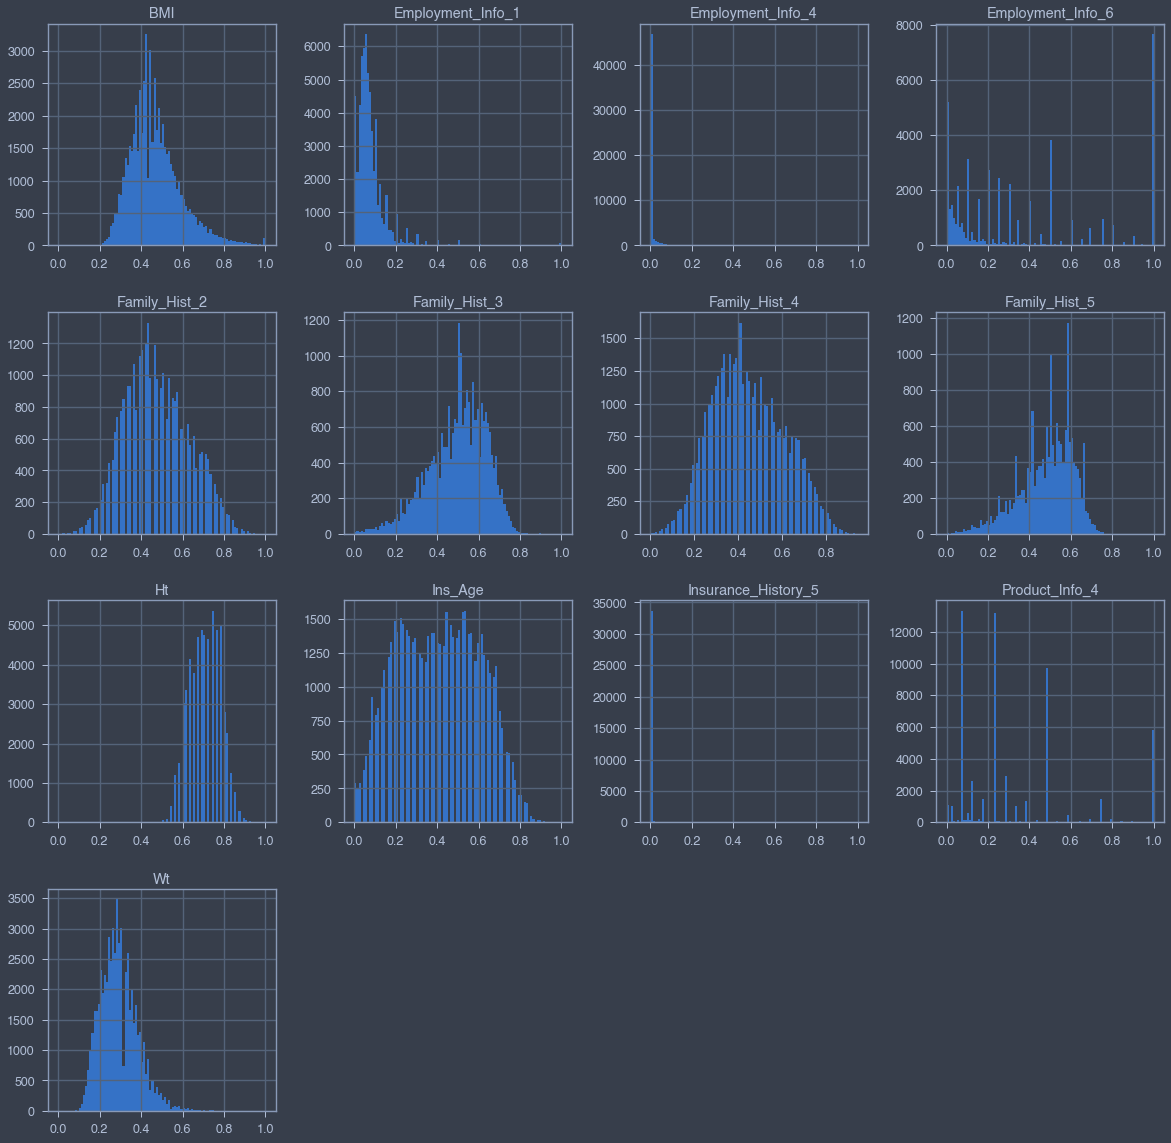

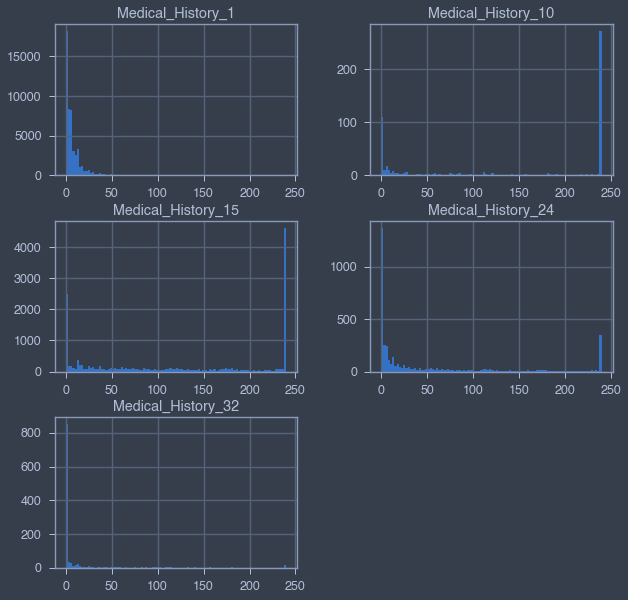

In [51]:
# Код 1. Постройте гистограммы.
data[real_features].hist(figsize=(20, 20), bins=100)
data[discrete_features].hist(figsize=(10, 10), bins=100)

__Ответьте на вопросы (Блок 2):__
* Есть ли константные признаки среди вещественных и целочисленных? Признак является константным, если множество его значений состоит из единственного элемента.
    * Ответ: Нет. (вопрос 3, блок 1)
* Предположим, что мы составили выборку, в которую вошли все только вещественные признаки. Можно ли ее описать многомерным нормальным распределением? $^*$
    * Ответ: Можно, при условии, что по каждому из признаков выборки можно построить одномерное нормальное распределение (их распределение будет напоминать купол в разрезе), случайными величинами выступают признаки.
    
$^*$ 
Плотность многомерного нормального распределения во всех проекциях на отдельные переменные должна быть симметрична, куполообразна, а значит, унимодальна.

Среди вещественных есть признаки с очень большим перекосом в сторону какого-то одного значения (например, Employmennt_Info_4), возможно, их стоило бы прологарифмировать при решении задачи. Кроме того, есть признаки со сложной структурой гистограммы. 
Распределения целочисленных признаков (относящихся к группе медицинских) имеют схожую структуру. 

В целом данные разнородны, и описать их одним вероятностным распределением непросто. 

##### Теперь визуализируем признаки попарно. 
Построим scatterplot для пар вещественных признаков. Для этого в seaborn есть функция pairplot. Исключим признаки, распределение которых не похоже на колокол (хотя бы скошенный и неровный), тем самым мы уменьшим размер таблицы пар. На диагоналях таблицы будут стоять оценки распределений признаков (гистограммы или восстановленные плотности, diag_kind="hist" или "kde"). Если указать параметр hue = дискретный целевой признак, то разные его значения будут отображаться разными цветами.

In [ ]:
seaborn.pairplot(data[real_features+["Response"]].drop(
        ["Employment_Info_4", "Employment_Info_6", "Insurance_History_5", "Product_Info_4"], axis=1), 
        hue="Response", diag_kind="kde")

Классы накрывают друг друга, и графики не очень информативны. Но они позволяют ответить на некоторые вопросы о взаимоотношениях признаков и соотношений признаков и классов.

__Ответьте на вопросы (Блок 3):__
* Есть ли пары признаков, у которых облака точек разных классов отличаются? Иными словами, есть ли графики, на которых видны облака разных классов, а не только последнего нарисованного?
    * Ответ: Да, например BMI и Family_Hist_4.
* Есть ли объекты-выбросы, то есть такие точки, которые стоят далеко от общего облака точек?
    * Ответ: Да, причем встречаются на большинстве графиков.

В целом облака точек выглядят достаточно компактно (в неформальном понимании этого слова), их можно приблизить искривленным кругом.

Теперь постройте такие же графики для целочисленных признаков (никакие признаки удалять не нужно, потому что таких признаков и так немного).

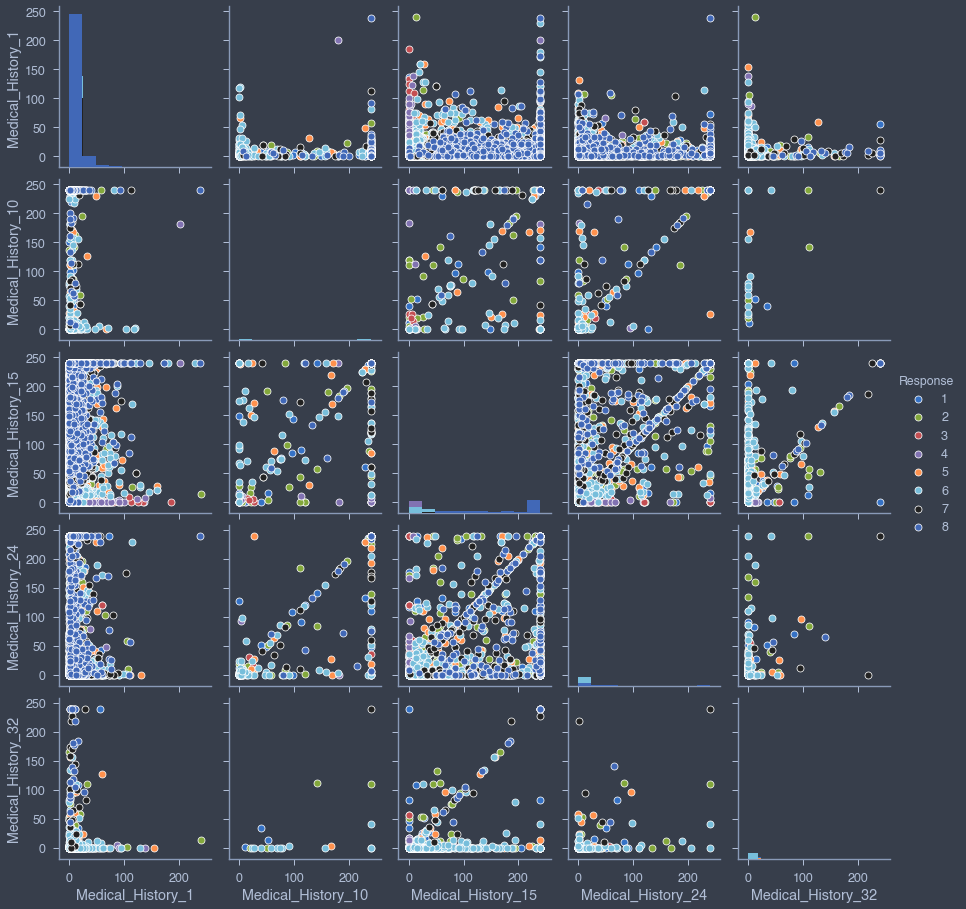

In [41]:
# Код 2. Постройте pairplot для целочисленных признаков
seaborn.pairplot(data[discrete_features+["Response"]], hue="Response", diag_kind="hist")

Графики выглядят еще менее информативно. Заметна тенденция, что пары признаков сконцентрированы либо на стороне квадрата [0, 240] x [0, 240], либо на его диагонали, то есть признаки как-то связаны.

##### Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед (гипотетическим) построением модели. 

Для визуализации матрицы попарных корреляций удобно использовать функцию seaborn.heatmap, она автоматически подпишет признаки на осях и покажет colorbar. Мы вычисляем корреляции только между вещественными признаками, для целочисленных признаков корреляции вычисляется по другим формулам.

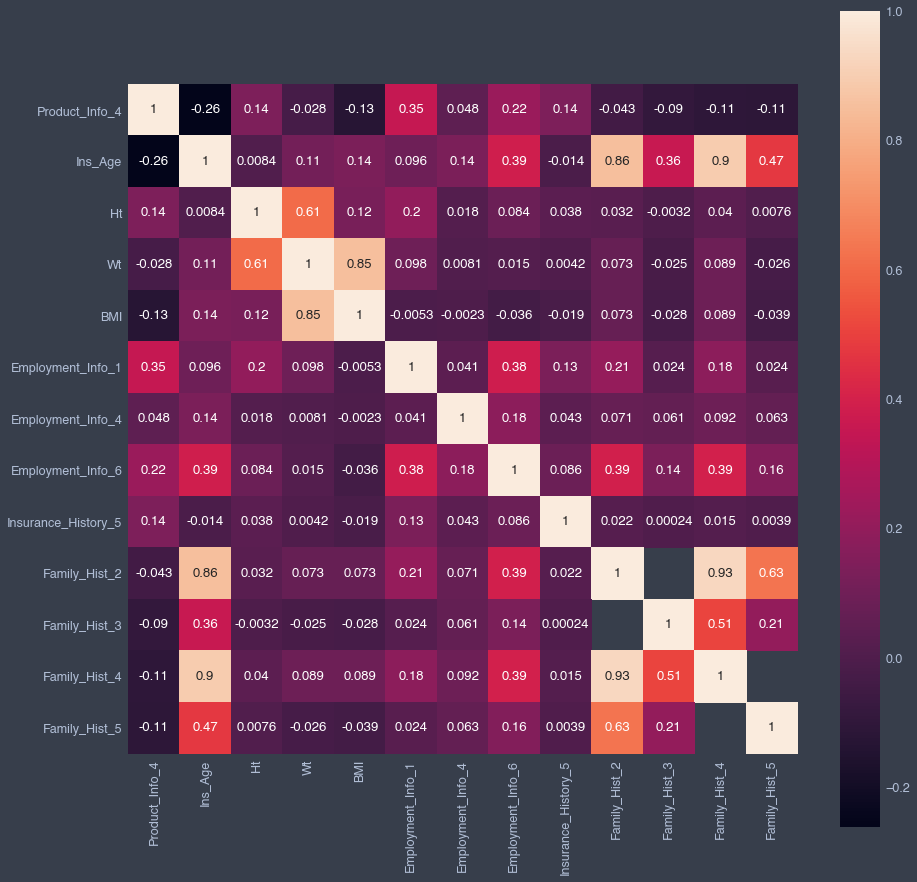

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
seaborn.heatmap(data[real_features].corr(), square=True, annot=True)

__Ответьте на вопрос (Блок 4)__:
* Есть ли пара (несовпадающих) признаков, корреляция между которыми больше 0.9? Если есть, то выпишите эту пару и точное значение корреляции. Напоминаем, что матрица корреляций симметрична, и дважды выписывать одну пару признаков не нужно.
    * Ответ: Есть: Family_Hist_2 и Family_Hist_4.

Перейдем к визуализации категориальных признаков.

##### Посчитаем количество значений для каждого признака.
Строим много графиков вручную (а не с помощью готовой функции, как с hist или pairplot). Для этого создаем новую pyplot-фигуру, указываем, сколько графиков на ней будет, задаем размер; параметр sharey говорит не подписывать все оси отдельно, а подписать их только один раз слева; здесь это уместно, потому что масштабы всех счетчиков одни и те же. 

В цикле по всем категориальным признакам строим countplot признака с помощью seaborn. Указываем параметр data, какой признак визуализировать, а также передаем ссылку на конкретную ячейку таблицы, в которой нужно изобразить график. Признаков всего 108, поэтому последние две ячейки таблицы графиков размером 11 x 10 останутся пустыми.

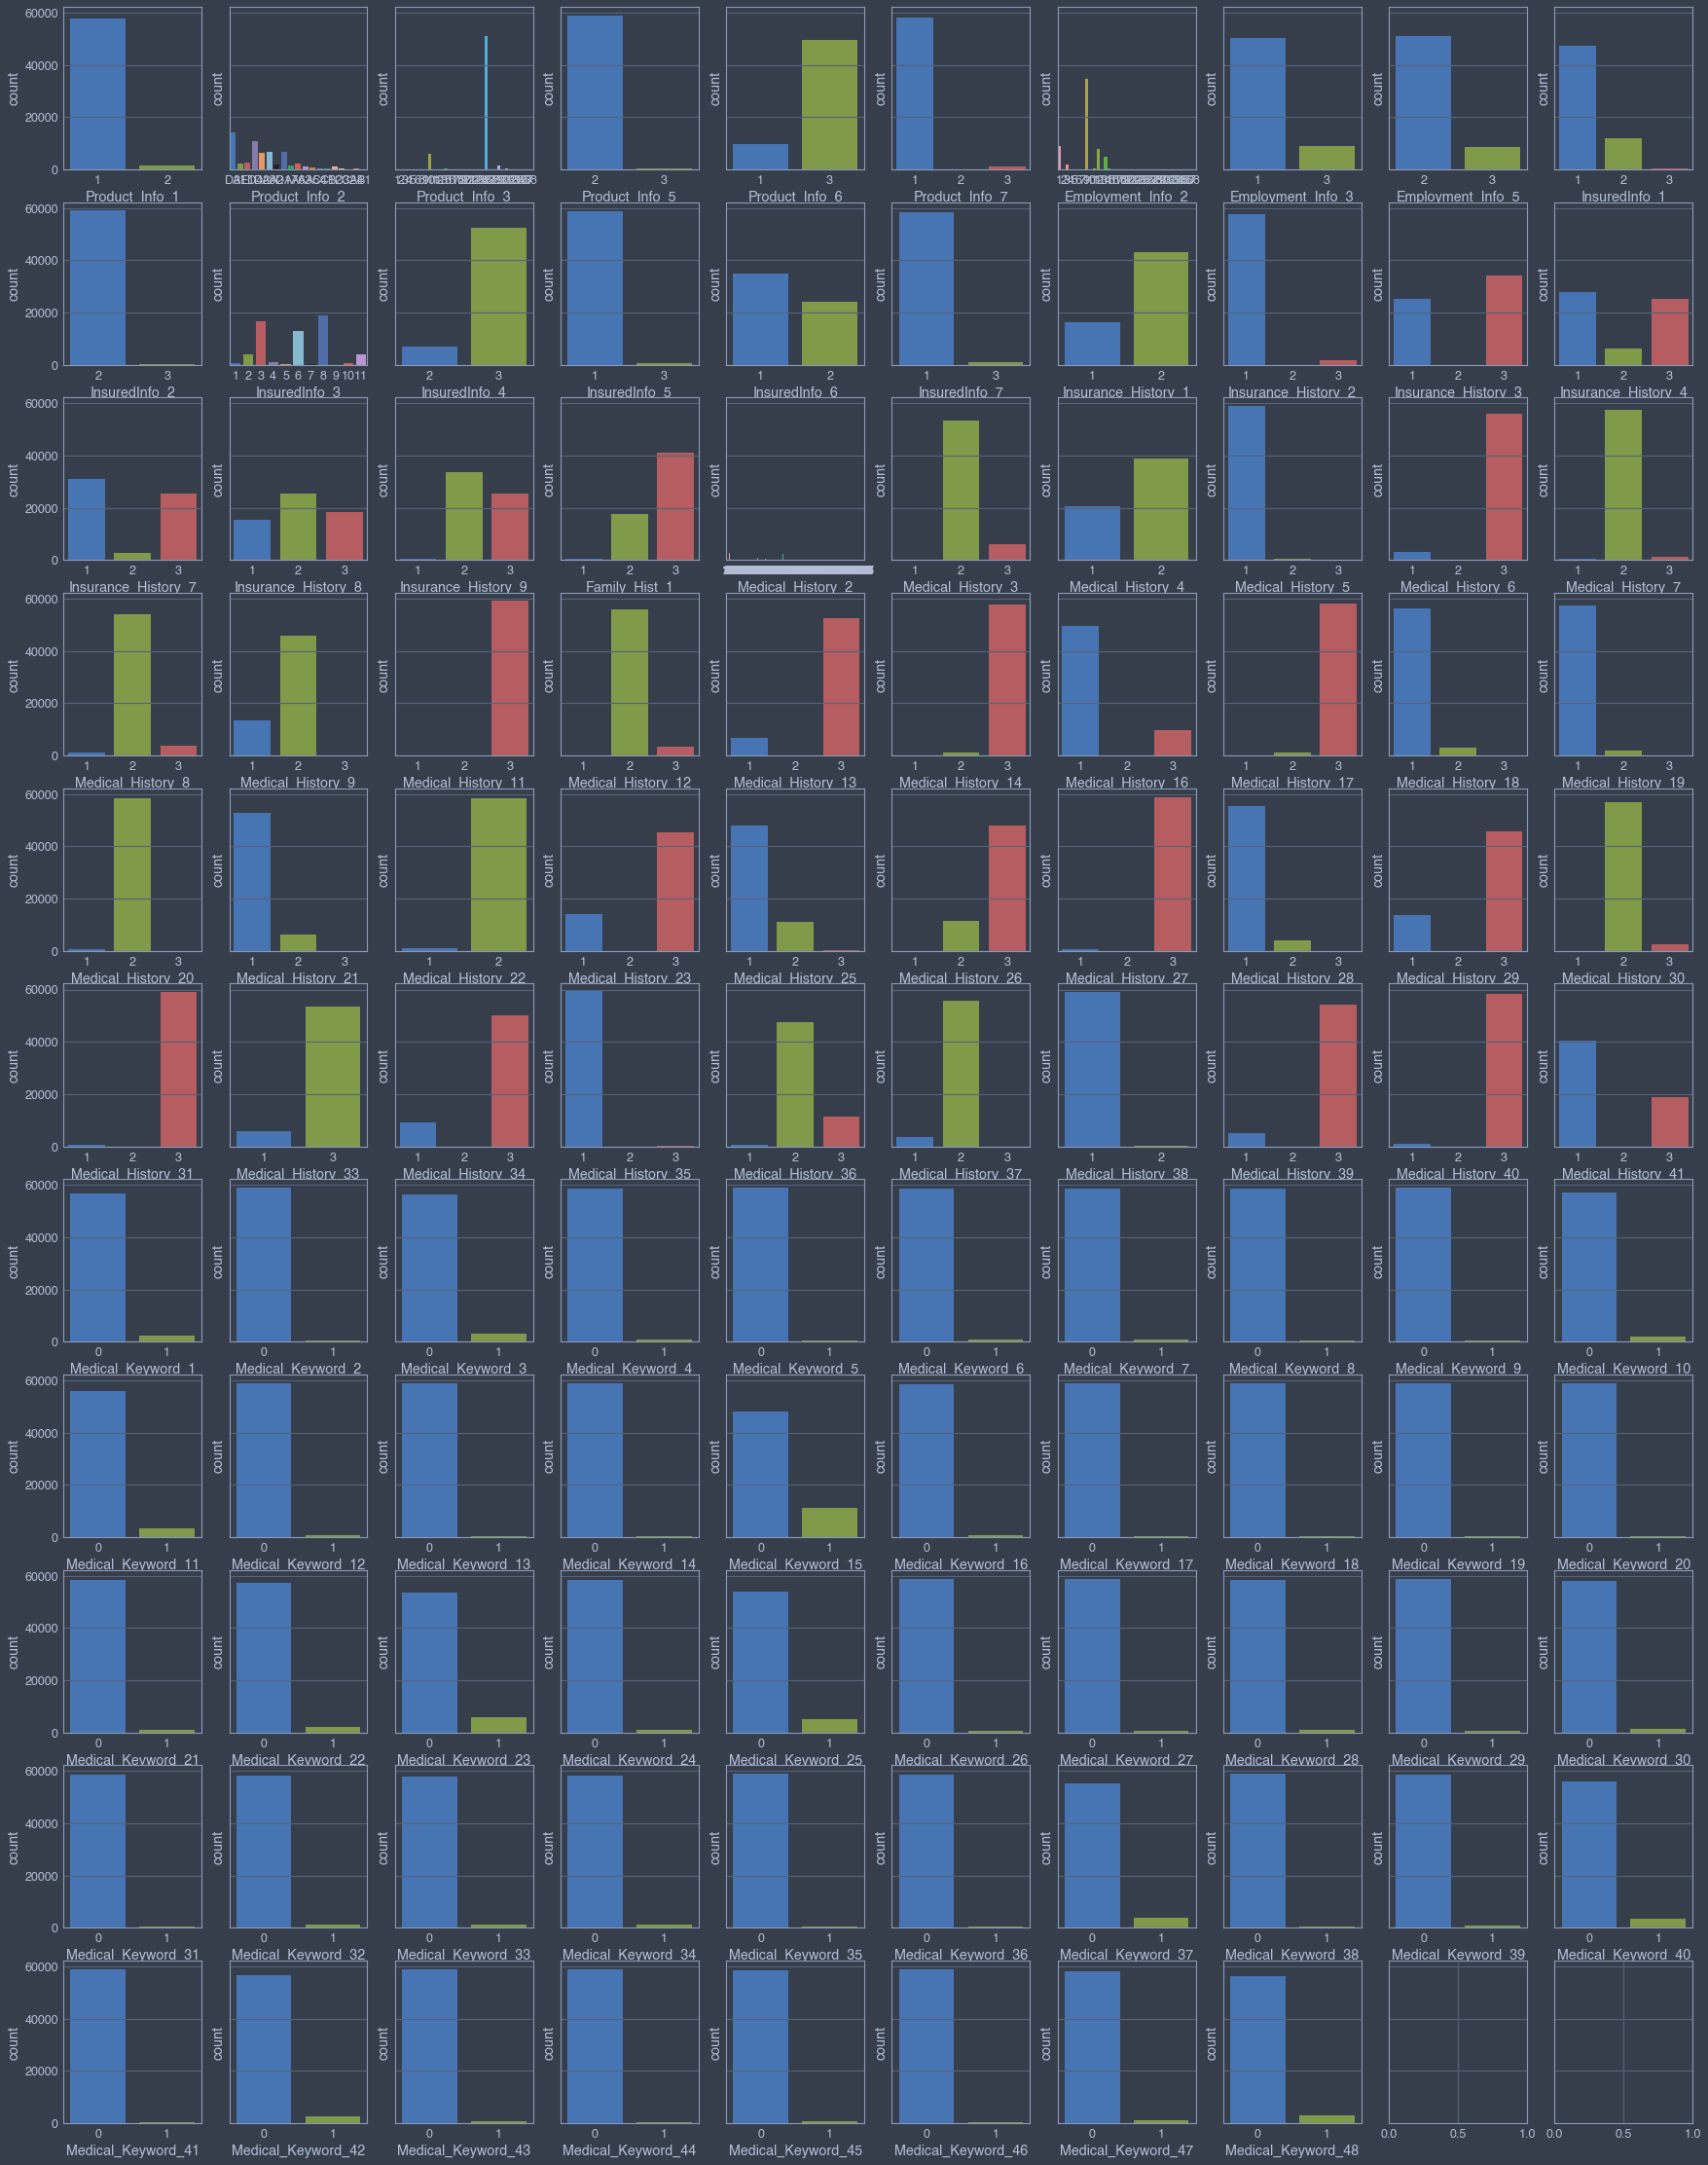

In [35]:
fig, axes = plt.subplots(11, 10, figsize=(30, 40), sharey=True)
for i in range(len(cat_features)):
    seaborn.countplot(x=cat_features[i], data=data, ax=axes[int(i / 10), i % 10])

In [22]:
mins, maxes, res = [], [], []
for i in cat_features:
    mins.append(data[i].min())
    maxes.append(data[i].max())
for el in zip(mins, maxes):
    print(el)
    if el[0] == el[1]:
        print('Есть const')
        break
else:
    print('Нет const')

(1, 2)
('A1', 'E1')
(1, 38)
(2, 3)
(1, 3)
(1, 3)
(1, 38)
(1, 3)
(2, 3)
(1, 3)
(2, 3)
(1, 11)
(2, 3)
(1, 3)
(1, 2)
(1, 3)
(1, 2)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 648)
(1, 3)
(1, 2)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 2)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 2)
(1, 3)
(1, 3)
(1, 3)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
Нет const


__Ответьте на вопросы (Блок 5)__:
* Есть ли среди категориальных признаков константные?
    * Ответ: Нет (Сверху проверка).
* Есть ли признаки с количеством возможных категорий (число значений признака) больше 5?
    * Ответ: Да, например InsuredInfo_3.

У нас есть много признаков с сильными перекосами в сторону отдельного признака. Учитывая, что среди категориальных признаков много медицинских показателей, можно предположить, что именно эти признаки сильно влияют на увеличение риска (целевой признак). Проверить это предположение можно, построив такие же countplot с разбивкой каждого значения дополнительно по классам (то есть у нас будет несколько групп столбиков, и в каждой группе их будет 8). Это можно сделать, указав параметр hue в этой функции аналогично тому, как мы это делали выше.

Постройте графики countplot для признаков 'Medical_Keyword_23', 'Medical_Keyword_39', 'Medical_Keyword_45' (признаки выбраны случайно) с разбивкой по классам.

(0, 'Medical_Keyword_23')
(1, 'Medical_Keyword_39')
(2, 'Medical_Keyword_45')


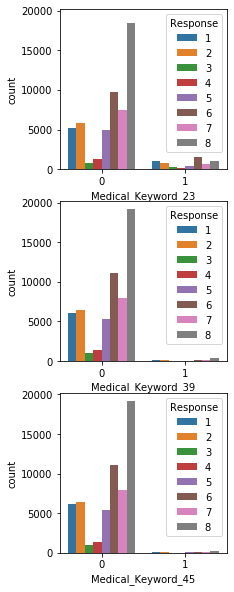

In [23]:
# Код 3. Постройте countplot
fig, axes = plt.subplots(3, figsize=(3, 10), sharey=True)
for obj in enumerate(['Medical_Keyword_23', 'Medical_Keyword_39', 'Medical_Keyword_45']):
    print(obj)
    seaborn.countplot(x=obj[1], data=data, ax=axes[obj[0]], hue="Response")

__Ответьте на вопрос (Блок 6)__:
* Наличие каких из этих трех факторов сильно повышает риск? Будем считать, что наличие признака сильно повышает риск, если количество человек, имеющих этот признак (то есть он для них равен 1) и отнесенных к категории риска 8, больше, чем такая же величина для любой другой категории риска.
    * Ответ: Наличие Medical_Keyword_45 и Medical_Keyword_39. Большая часть людей, имеющих эти признаки, относятся к категории риска 8.

##### Наконец, посмотрим на распределение целевого признака, чтобы узнать, сбалансированы ли классы:

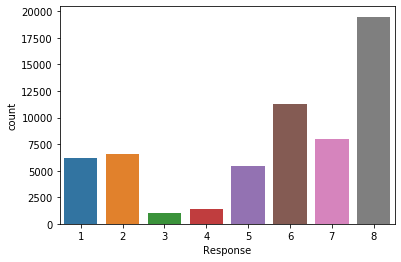

In [24]:
seaborn.countplot(data.Response)

В категорию 8 люди попадают чаще, чем в другие категории.

### Визуализация с помощью понижения размерности

Далее можно воспользоваться средствами понижения размерности. Для задачи с дискретным целевым признаком это позволит понять, какие классы хорошо разделяются, а какие - нет.

Такие методы строят матрицу попарных расстояний между объектами, которая в случае, когда объектов много, будет занимать много памяти. Кроме того, отображать много точек на scatter plot (а именно его используют для визуализации результата понижения размерности) неудобно. Поэтому мы перемешаем выборку (и далее будем использовать ее) и выберем првые 1000 объектов для понижения размерности. Вы можете попробовать взять больше объектов.

In [10]:
from sklearn.utils import shuffle
from sklearn.preprocessing import scale

In [11]:
sdata = shuffle(data, random_state=321)
# del data   # удалите неперемешанные данные, если не хватает оперативной памяти

Методы sklearn не принимают матрицы с пропусками (nan). Чтобы избежать этой проблемы, не будем рассматривать признаки, которые имеют много пропусков (последние четыре в списке вещественных признаков). Кроме того, ограничимся рассмотрением вещественных признаков.

В следующей ячейке мы отбираем нужные признаки, затем находим объекты, у которых все признаки известны (нет пропусков в выбранных признаках), а затем создаем отдельно матрицу объекты-признаки для работы методов понижения размерности и отдельно вектор правильных ответов на этих объектах: data_subset и response_subset. Кроме того, мы дополнительно стандартизуем нашу маленькую выборку, потому что методы понижения размерности очень чувствительны к разномасштабным данным (это отдельно указано в [туториале](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) в sklearn)

In [12]:
subset_l  = 1000
selected_features = real_features[:-4]
objects_with_nan = sdata.index[np.any(np.isnan(sdata[selected_features].values), axis=1)]   
data_subset = scale(sdata[selected_features].drop(objects_with_nan, axis=0)[:subset_l])
response_subset = sdata["Response"].drop(objects_with_nan, axis=0)[:subset_l]

Будем строить визуализацию методом t-SNE

In [13]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

Методы понижения размерности имеют такой же интерфейс, как классификаторы и регрессоры. Для построения визуализации t-SNE нужно создать объект класса и вызвать его метод fit_transform, который вернет матрицу размера число объектов x новая размерность; по умолчанию новая размерность равна 2. Выполните эти действия и запишите результат работы метода в переменную tsne_representation. Рекомендуем ознакомиться с параметрами метода на [странице документации TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE). <font color="red"> Зафиксируйте случайное приближение random_state=321, чтобы результат визуализации у всех был одинаковый. </font> 

In [14]:
# Код 4. Присвойте переменной tsne_representation результат понижения размерности методом tSNE с параметрами по умолчанию
tsne_representation = TSNE(random_state=321).fit_transform(data_subset)

Визуализируем полученное представление. Для этого создадим набор цветов по количеству классов, а затем в цикле по классам будем отображать представления точек, относящихся к этому классу. Будем указывать параметр alpha=0.5, чтобы сделать точки полупрозрачными, это лучше в ситуации, когда точки накладываются.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

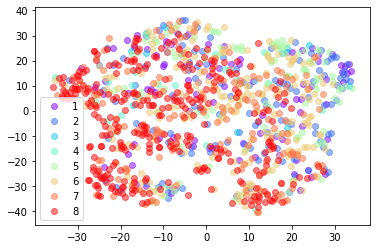

In [15]:
def show_plt():
    colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
    for y, c in zip(set(data.Response), colors):
        plt.scatter(tsne_representation[response_subset.values==y, 0], 
                    tsne_representation[response_subset.values==y, 1], c=c, alpha=0.5, label=str(y))
    plt.legend()
show_plt()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

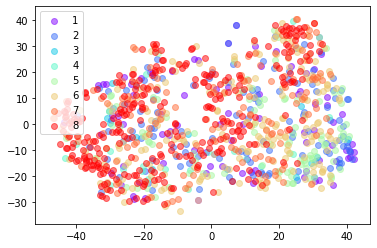

In [16]:
tsne_representation = TSNE(metric='braycurtis', random_state=321).fit_transform(data_subset)
show_plt()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

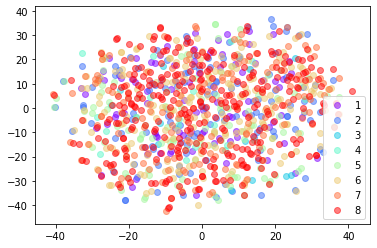

In [17]:
tsne_representation = TSNE(metric='hamming', random_state=321).fit_transform(data_subset)
show_plt()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

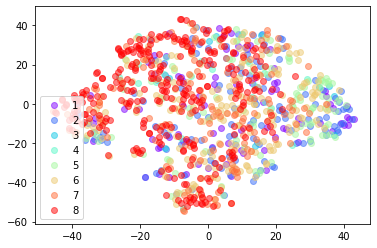

In [18]:
tsne_representation = TSNE(metric='minkowski', random_state=321).fit_transform(data_subset)
show_plt()

Для построения представления можно пробовать разные метрики, их список доступен в [документации scipy](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html) (потому что sklearn использует метрики scipy). Используйте 3 разные метрики в t-SNE и посмотрите получающиеся визуализации (в t_SNE метрику можно указать при создании объекта класса TSNE)

__Ответьте на вопросы (Блок 7)__:
* Есть ли визуализации, на которой классы хорошо разделяются? Классы хорошо разделяются, если между облаками точек разных классов можно проводить границы. 
    * Ответ: Нет.
* Есть ли визуализации, по которым видно, что объекты с наименьшим риском (1 и 2) отличаются от объектов с высоким риском (7 и 8)? Будем считать, что объекты классов A и B отличаются, если можно выделить область плоскости, в которой в целом больше точек класса A, и можно выделить область, в которой больше точек класса B. Если есть, укажите хотя бы одну такую визуализацию.
    * Ответ: Да, при метриках 'braycurtis' и 'minkowski', примерно.
* Есть ли визуализации, на которых видны отдельно стоящие (от общего облака) точки? Если есть, укажите хотя бы одну такую визуализацию.
    * Ответ: Да, например в 'braycurtis': две точки сверху особенно выделяются

Визуализации разными методами достаточно сильно отличаются, но на каждой можно условно выделить направление, вдоль которого происходит увеличение риска от 1 до 8 (то есть точки постепенно меняют цвет). Если бы это не выполнялось, можно было бы предположить, что задача не решаема.

### Поиск аномалий

Воспользуемся методами поиска выбросов, рассмотренными в лекции.

##### Z-score
Для простоты выберем вещественные признаки, которые известны для всех объектов: Product_Info_4, Ins_Age, Ht, Wt, BMI. Оставим только те, которые относятся к человеку, то есть не будем рассматривать Product_Info_4. Получится, что мы отбираем нестандартных по комбинации вес/рост/возраст людей.



Попытаемся визуализировать, какие объекты отнесены к шумовым. Для этого нужно построить scatter-графики для каждой пары признаков в person_features (всего 6 графиков). На каждом графике нужно отдельно отобразить точки с Z-score критерием вне нормы (используйте правило 3х сигм)

Создайте pyplot-фигуру с 6 графиками: 2 x 3, укажите размер фигуры (12, 8). Затем в цикле по __парам признаков__ из person_features отобразите scatter-графики точек (сделайте точки с разными labels разных цветов: синие, c="blue", - обычные точки, у которых z-score<=3$\sigma$, красные, c="red",  - шумовые, у которых z-score>3$\sigma$.) Для построения графика можно пользоваться командой axes[...].scatter(...), вместо ... - ваш код. Функция scatter принимает два вектора одинаковой длины, абсциссы и ординаты точек, и дополнительные параметры, например, цвет c и коэффициент прозрачности точек alpha. Подпишите оси названиями признаков, это можно сделать с помощью команды axes[...].set_xlabel(...) или axes[...].ylabel(...).

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


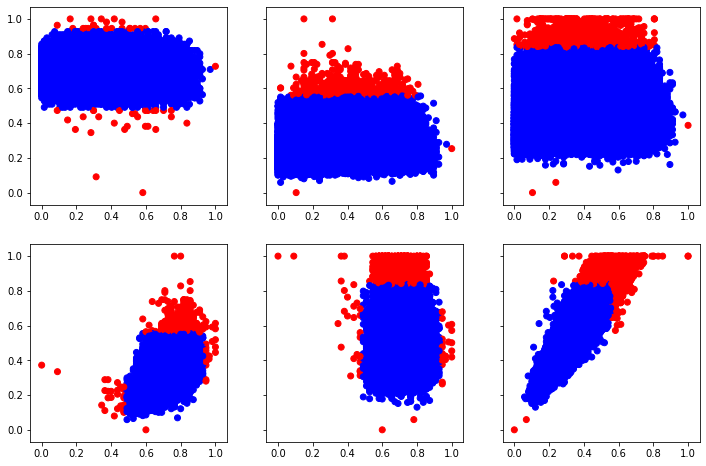

In [46]:
# Код 7. Постройте 6 графиков
from itertools import combinations, combinations_with_replacement
from scipy import stats
#a = combinations_with_replacement([0,1,2], 2)

person_features = ['Ins_Age', 'Ht', 'Wt', 'BMI']

def axs():
    for i in range(2):
        for j in range(3):
            yield [i, j]
            
gen_iter_axs = axs()

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
for [a1,b1],[a2,b2] in zip(iter(gen_iter_axs), combinations(person_features, 2)):
    arr1 = sdata[np.abs(stats.zscore(sdata[a2])) > 3]
    arr2 = sdata[np.abs(stats.zscore(sdata[b2])) > 3]
    sdata['colour'] = np.ones(sdata.shape[0])
    sdata['colour'][sdata['Id'].isin(set(list(arr1['Id']) + list(arr2['Id'])))] = False
    axes[a1, b1].scatter(sdata[a2], sdata[b2], c=sdata['colour'].map({True: 'b', False: 'r'}))



Вы должны увидеть, что, во-первых, облака синие точки заполняют почти все облако точек, а во-вторых, красные точки находятся на границе или далеко от облака (интуитивно понятно, что это аномальные объекты). 

##### Непараметрическое восстановление плотности.
Искать аномалии можно, анализируя непараметрически восстановленную плотность одномерного распределения. Так можно заметить, что какие-то объекты выбиваются из общей тенденции. 

В seaborn это удобно делать с помощью метода distplot. Посмотрев на гистограммы в начале ноутбука, выберем для ближайшего рассмотрения признаки BMI, Employment_Info_1, Medical_History_32. 

Примените метод distplot к этим трем признакам, указав bins=50. Рекомендуется удалять значения nan с помощью метода датафрейма .dropna().

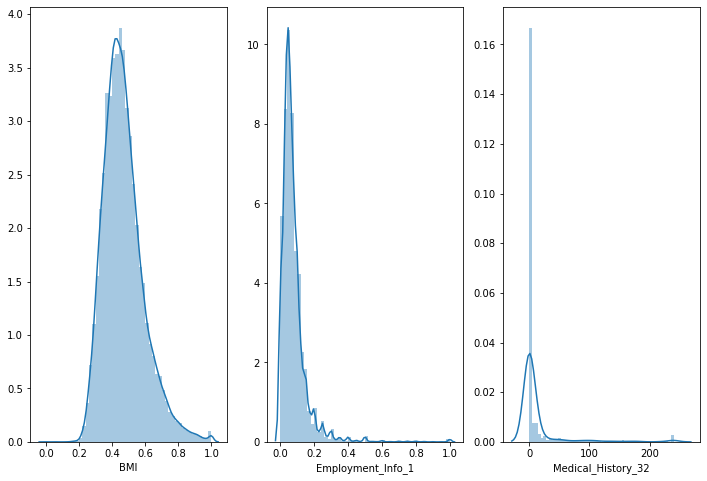

In [71]:
# Код 8. Восстановите плотности для трех указанных признаков
fig, axes = plt.subplots(1, 3, figsize=(12,8))
seaborn.distplot(sdata['BMI'].dropna(), bins=50, ax=axes[0])
seaborn.distplot(sdata['Employment_Info_1'].dropna(), bins=50, ax=axes[1])
seaborn.distplot(sdata['Medical_History_32'].dropna(), bins=50, ax=axes[2])

На трех графиках видно, что в конце множества значений признака есть скачок, и это явление очень похоже на аномалию.

### Заключение
Мы познакомились с методами визуализации и отбора шумовых объектов и посмотрели на примере, с чего стоит начинать работу с новым датасетом. Как и в других методах анализа данных, в методах визуализации приходится подбирать параметры, но здесь эта задача осложняется отсутствием автоматически вычисляемого критерия качества визуализации, и подбирать параметры приходится вручную.